## BERT (Bidirectional Encoder Representations from Transformers)

Se realizará un proceso de ajuste fino (fine-tuning) de un modelo BERT previamente entrenado en artículos con etiquetas conocidas. Posteriormente, este modelo podrá ser utilizado para clasificar noticias desconocidas y determinar su temática.


### Imports

In [43]:

import random
import re # Regular expressions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


# Ajustamos el nivel de logging a ERROR para ocultar los mensajes de INFO y WARNING
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahmat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga de datos

In [12]:
df = pd.read_csv('../data/bbc_data.csv')
df.rename(columns={'data': 'text', 'labels': 'category'}, inplace=True)
df.head()

,text,category
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


### Preprocesamiento de datos

#### Codificación de etiquetas

In [13]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'entertainment': 0, 'business': 1, 'sport': 2, 'politics': 3, 'tech': 4}

In [16]:
df['label'] = df.category.replace(label_dict)
df.head()

,text,category,label
0,Musicians to tackle US red tape Musicians gro...,entertainment,0
1,"U2s desire to be number one U2, who have won ...",entertainment,0
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment,0
3,Snicket tops US box office chart The film ada...,entertainment,0
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,0


#### Preprocesamiento del texto

In [15]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Eliminación de números
    text = re.sub(r'\d+', '', text)
    # Eliminación de caracteres especiales
    text = re.sub(r'\W', ' ', text)
    # Eliminación de stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english')) 
    return text

In [17]:
df['text'] = df['text'].apply(preprocess_text)
df.head()

,text,category,label
0,musicians tackle us red tape musicians groups ...,entertainment,0
1,us desire number one u three prestigious gramm...,entertainment,0
2,rocker doherty stage fight rock singer pete do...,entertainment,0
3,snicket tops us box office chart film adaptati...,entertainment,0
4,oceans twelve raids box office oceans twelve c...,entertainment,0


#### Split de datos para BERT

In [18]:
def get_split(text):
    words = text.split()
    total_words = len(words)
    chunk_size = 200
    overlap = 50
    step = chunk_size - overlap

    if total_words <= chunk_size:
        return [text]

    chunks = []
    for start in range(0, total_words, step):
        end = start + chunk_size
        chunk = " ".join(words[start:end])
        chunks.append(chunk)

    return chunks

In [19]:
split_df = df.copy()
split_df['split'] = split_df['text'].apply(get_split)
split_df.head()

,text,category,label,split
0,musicians tackle us red tape musicians groups ...,entertainment,0,[musicians tackle us red tape musicians groups...
1,us desire number one u three prestigious gramm...,entertainment,0,[us desire number one u three prestigious gram...
2,rocker doherty stage fight rock singer pete do...,entertainment,0,[rocker doherty stage fight rock singer pete d...
3,snicket tops us box office chart film adaptati...,entertainment,0,[snicket tops us box office chart film adaptat...
4,oceans twelve raids box office oceans twelve c...,entertainment,0,[oceans twelve raids box office oceans twelve ...


In [20]:
def flatten_column(df):
    """
    Flattens the specified column of a DataFrame into individual elements,
    associating each element with its corresponding label and index.
    
    Returns:
    tuple: Three lists containing the flattened column elements, corresponding labels, and indices.
    """
    column_elements = []
    category_elements = []
    label_elements = []

    for idx, row in df.iterrows():
        for element in row['split']:
            column_elements.append(element)
            category_elements.append(row['category'])
            label_elements.append(row['label'])
    
    return column_elements, category_elements, label_elements

In [21]:
text_l, category_l, label_l = flatten_column(split_df)
bert_df = pd.DataFrame({'text': text_l, 'category': category_l, 'label': label_l})
bert_df.head()

,text,category,label
0,musicians tackle us red tape musicians groups ...,entertainment,0
1,us market seen holy grail one benchmarks succe...,entertainment,0
2,us desire number one u three prestigious gramm...,entertainment,0
3,band done everything considerable powers ensur...,entertainment,0
4,songs like sunday bloody sunday new years day ...,entertainment,0


#### Split de datos para entrenamiento y testeo

In [22]:
X_train, X_val, y_train, y_val = train_test_split(bert_df.index.values, 
                                                  bert_df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=bert_df.label.values)

In [23]:
bert_df['data_type'] = ['not_set']*bert_df.shape[0]

bert_df.loc[X_train, 'data_type'] = 'train'
bert_df.loc[X_val, 'data_type'] = 'val'

bert_df.groupby(['category', 'label', 'data_type']).count()

text
category      label data_type      
business      1     train       598
                    val         150
entertainment 0     train       451
                    val         113
politics      3     train       665
                    val         166
sport         2     train       601
                    val         150
tech          4     train       719
                    val         180

### BERT Tokenizer

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
encoded_data_train = tokenizer.batch_encode_plus(
    bert_df[bert_df.data_type=='train'].text.values, 
    add_special_tokens=True, # Add [CLS] and [SEP] tokens at the beginning and end of each sentence
    return_attention_mask=True, # Attention masks
    pad_to_max_length=True, # Padding
    max_length=256, # Tamaño máximo de la secuencia
    return_tensors='pt' # Return PyTorch tensors
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(bert_df[bert_df.data_type=='train'].label.values)

c:\Users\ahmat\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [27]:
encoded_data_val = tokenizer.batch_encode_plus(
    bert_df[bert_df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(bert_df[bert_df.data_type=='val'].label.values)

In [28]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(3034, 759)

### BERT from pre-trained model

In [29]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

#### Data Loaders

In [30]:
batch_size = 3
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

#### Optimizer and scheduler

In [31]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

c:\Users\ahmat\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Metrics

In [33]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def precision_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, preds_flat, average='weighted')

def recall_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='weighted')

def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#### Training and evaluation

In [36]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [40]:
def evaluate(model_to_evaluate, dataloader_val):
    model_to_evaluate.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model_to_evaluate(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [90]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model, dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1012 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2823709606654526
Validation loss: 0.17123412908553678
F1 Score (Weighted): 0.9655609524525839


Epoch 2:   0%|          | 0/1012 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.10388365186703265
Validation loss: 0.13282264063821317
F1 Score (Weighted): 0.9723514140247191


Epoch 3:   0%|          | 0/1012 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.05127869044852617
Validation loss: 0.13440831445673804
F1 Score (Weighted): 0.9710191306431812


### Evaluating the model

#### Fine-tuning through epochs

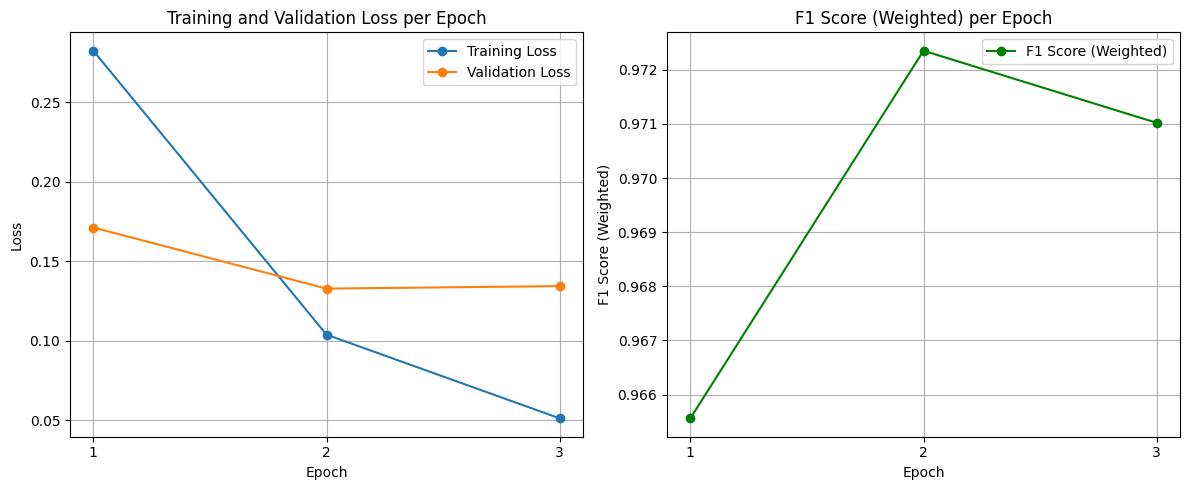

In [54]:
ft_epochs_df = pd.read_csv('finetuned_BERT_info.csv')

# Crear figura y subgráficos
fig, ax1 = plt.subplots(1, 2, figsize=(12, 5))

# Subgráfico 1: Pérdidas de entrenamiento y validación
ax1[0].plot(ft_epochs_df['Epoch'], ft_epochs_df['Training loss'], label='Training Loss', marker='o')
ax1[0].plot(ft_epochs_df['Epoch'], ft_epochs_df['Validation loss'], label='Validation Loss', marker='o')
ax1[0].set_xlabel('Epoch')
ax1[0].set_xticks(ft_epochs_df['Epoch'])
ax1[0].set_ylabel('Loss')
ax1[0].set_title('Training and Validation Loss per Epoch')
ax1[0].legend()
ax1[0].grid(True)

# Subgráfico 2: F1 Score por época
ax1[1].plot(ft_epochs_df['Epoch'], ft_epochs_df['F1 Score (Weighted)'], label='F1 Score (Weighted)', marker='o', color='green')
ax1[1].set_xlabel('Epoch')
ax1[1].set_xticks(ft_epochs_df['Epoch'])
ax1[1].set_ylabel('F1 Score (Weighted)')
ax1[1].set_title('F1 Score (Weighted) per Epoch')
ax1[1].legend()
ax1[1].grid(True)

# Ajustar el diseño
plt.tight_layout()
plt.show()

#### Fine-tuned vs. No fine-tuned

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ft_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(label_dict),output_attentions=False, output_hidden_states=False)
ft_model.to(device)

n = 2
ft_model.load_state_dict(torch.load(f'finetuned_BERT_epoch_{n}.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(ft_model, dataloader_validation)
f1 = f1_score_func(predictions, true_vals)
precision = precision_func(predictions, true_vals)
recall = recall_func(predictions, true_vals)
accuracy = accuracy_func(predictions, true_vals)
# accuracy_per_class(predictions, true_vals)

finetuned_df = pd.DataFrame({'Metric': ['F1 Score', 'Precision', 'Recall', 'Accuracy'], 'Value': [f1, precision, recall, accuracy]})
# finetuned_df

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nft_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(label_dict),output_attentions=False, output_hidden_states=False)
nft_model.to(device)

_, predictions, true_vals = evaluate(nft_model, dataloader_validation)
f1 = f1_score_func(predictions, true_vals)
precision = precision_func(predictions, true_vals)
recall = recall_func(predictions, true_vals)
accuracy = accuracy_func(predictions, true_vals)
# accuracy_per_class(predictions, true_vals)

nofinetuned_df = pd.DataFrame({'Metric': ['F1 Score', 'Precision', 'Recall', 'Accuracy'], 'Value': [f1, precision, recall, accuracy]})
# nofinetuned_df

c:\Users\ahmat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
finetuned_df['Model'] = 'Finetuned'
nofinetuned_df['Model'] = 'No Finetuned'

# Combinar los DataFrames
combined_df = pd.concat([finetuned_df, nofinetuned_df])

# Pivotar el DataFrame para que sea adecuado para el heatmap
pivot_df = combined_df.pivot(index='Metric', columns='Model', values='Value')
pivot_df

Model,Finetuned,No Finetuned
Metric,,
Accuracy,0.972332,0.221344
F1 Score,0.972351,0.137776
Precision,0.972419,0.120940
Recall,0.972332,0.221344
